# Step 1: Setup Workspace

In [1]:
#Import libraries
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#Input values
fleet_size = [50000,10000,1000]
mean_dvmt = [45,35,25]
temp_c = [40,30,20,10,0,-10,-20]
pev_type = ['PHEV20','PHEV50','BEV100','BEV250']
pev_dist = ['EQUAL_DIST','PHEV_DOM','BEV_DOM']
vehicle_class_dist = ['Sed20_Suv80','Sed50_Suv50','Sed80_Suv20']
day_of_week = ['weekday','weekend']
home_access = ['HA100','HA75','HA50',]
home_power_dist = ["L2"]
work_power_dist = ['L2_20','L2_50','L2_100']
pref_dist = ['Home60','Home80','Home100']
dest_type = ['Home','Public','Work']
dest_chg_level = ['L1','L2','L3']


def selection_API_Run(fleet_size,mean_dvmt,temp_c,pev_type,pev_dist,vehicle_class_dist,home_access,work_power_dist,pref_dist,dest_chg_level,day_of_week,dest_type,test=0):    
    params=[]
    #Don't need home_power_dist since it only has one choice
    #day_of_week and dest_type are used to generate plots- therefore all selections are used (and they are omitted from choice selection)
    
    for var_name,var in zip(["fleet size","mean daily vehicle miles traveled","temperature (C)","PEV distribution","vehicle class distribution","% of homes with home charging access","% of L2 work charging (remainder is L1)","percent of charging done at home (for those who have it)"],[fleet_size,mean_dvmt,temp_c,pev_dist,vehicle_class_dist,home_access,work_power_dist,pref_dist]):
        if test!=1:
            print("Please select a value for "+var_name+".")
            for i in range(0,len(var)):
                print(str(i)+") "+str(var[i]))   
            while True:
                selection=-1
                try:
                    selection = int(input("Enter an integer selection from above (Ex. 0, 1, 2..): ")) #User selects parameter choice from list
                except:
                    pass
                if selection in list(range(len(var))):
                    break
                else:
                    print("Select just one of the numbers corresponding to a choice from the above listed parameter values.")
             
            params.append(var[selection])         #Will be a list of parameters in the order listed in the for loop
            print("\n")
        else:
            print(var[0])
            params.append(var[0])

    #Generate load profiles for home, public, and work on both weekends and weekdays and for different charger levels according to the selected parameters
    print("Running simulation according to selected parameters...")
    record_json={}
    for dow in day_of_week:
        record_json[dow]={}
        for location in dest_type:
            for chg_level in dest_chg_level:
                print(dow,location,chg_level)
                #Skip home/work level 3 or public level 1
                if (location=="Home" and chg_level!="L3") or (location=="Public" and chg_level!="L1") or (location=="Work" and chg_level!="L3"): 
                    for pev in pev_type:
                        if (pev[0:4]=="PHEV" and chg_level=="L3"): #Skip PHEV and L3
                            pass
                        else:
                            url = """https://devstage.nrel.gov/api/evi-pro-lite-beta/load-profile?fleet_size=%s&mean_dvmt=%s&temp_c=%s&pev_dist=%s&vehicle_class_dist=%s&home_access=%s&home_power_dist=L2&work_power_dist=%s&pref_dist=%s&dest_chg_level=%s&day_of_week=%s&dest_type=%s&pev_type=%s""" %(params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7],chg_level,dow,location,pev)
                            url=url.replace("\\", "")
                            record_str = requests.get(url).text
                            record_str = record_str.replace("'", "\"")
                            raw_json=json.loads(record_str)
                            try:
                                raw_json['load_profile']
                            except KeyError:
                                print(dow,location,chg_level,pev,": ",raw_json['errors'])
                                current_results = np.zeros(96)
                            else:
                                current_results=[float(i) for i in raw_json['load_profile']] #Parse the JSON
                                #If we haven't saved data for this location and charger level, create a new dictionary entry. Otherwise, add to the existing
                            try:
                                record_json[dow][location,chg_level]
                            except KeyError:
                                record_json[dow][location,chg_level] = current_results
                            else:
                                record_json[dow][location,chg_level]=[x + y for x, y in zip(record_json[dow][location,chg_level], current_results)]
                else:
                    pass
    record_json_df=pd.DataFrame(record_json)
    print("Simulation Run Complete")
    return record_json_df,params[0] #return results and selected fleet size

##Stack Plot
def loadPlotting(day):
    fig = plt.figure(figsize = (12,5))
    ax = plt.axes()
    xaxis_labels = [(x * 15.0)/60.0 for x in range(0,96)]

    ax.stackplot(xaxis_labels,result[day][0],result[day][1],result[day][2],result[day][3],result[day][4],result[day][5])
    
    plt.legend(result['weekday'].keys(),fontsize = 14,loc = 'upper left')
    plt.xlabel('Hour of Day',size=18)
    plt.ylabel('Grid Load [kW]',size=18)
    plt.title(day.capitalize()+' Fleet-wide Grid load',size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)

    ymin, ymax = ax.get_ylim()
    ax.set_xlim([0,24])
    if size == 50000:
        ax.set_ylim([0,200000])
    elif size == 10000:
        ax.set_ylim([0,35000])
    elif size == 1000:
        ax.set_ylim([0,3500])   
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))   


# Step 2: Specify Parameters and Call API

In [ ]:
result,size = selection_API_Run(fleet_size,mean_dvmt,temp_c,pev_type,pev_dist,vehicle_class_dist,home_access,work_power_dist,pref_dist,dest_chg_level,day_of_week,dest_type,2)

# Step 3: Plotting

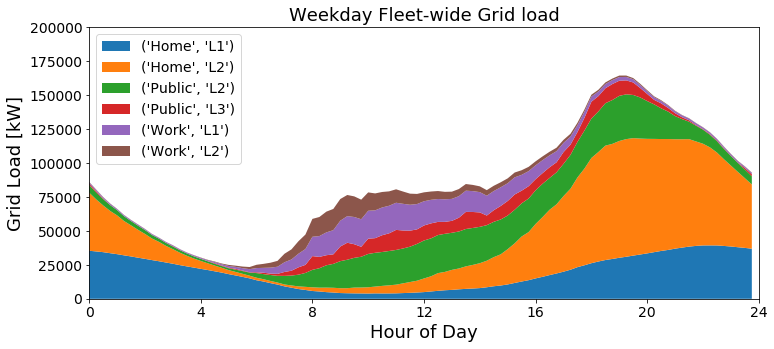

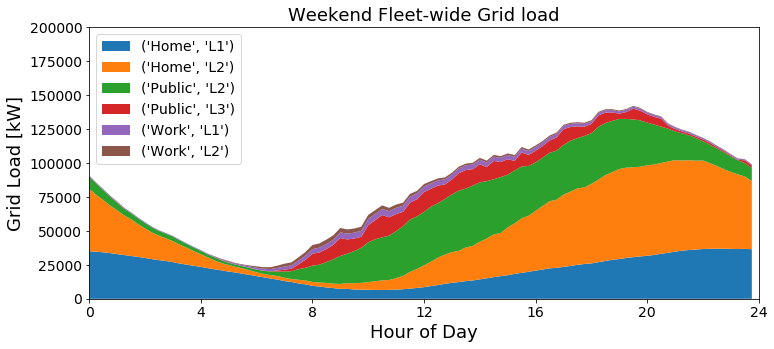

In [4]:
loadPlotting('weekday')
loadPlotting('weekend')